## The raw data released for GCF was a gtf file, while the alterantive in CHO Genome was as a gff3 file. Need to see the differences.

## Process both the alternative annotation and GCF annotation for downstream processing

In [37]:
## Parameters specific to where your folders are and your data
parameter_file = '../parameters/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']

import tqdm
import os
from os.path import join
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
from tqdm import *
from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import helper
import create_output
print('Number of tissues: ',len(tissues))

from collections import Counter

from tss.data.generate_genome import expand_anno_id

from os.path import join

from Homer import *

doc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of tissues:  13


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


{'data_folder': '/data/isshamie/TSS/NCBI_PICR_103_Processed/',
 'results': '/data/isshamie/TSS/Analysis/Analysis_03302020/Results/',
 'figures': '/data/isshamie/TSS/Analysis/Analysis_03302020/Results/',
 'RNAseq_QC': '/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/2017_12_15_hamster_Seq/fastqc/',
 'RNAseq_folder': '/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/2017_12_15_hamster_Seq/',
 'pipeline_path': '/data/isshamie/TSS/Analysis/src/',
 'tissues': 'BMDM1hKLA,BMDMwt,Brain,FemaleReproductive,Heart,Kidney,Liver,Lung,MiscOrgans,Muscle,Pancreas,Spleen,CHO',
 'ref_fa': '/data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.fna',
 'annotation': '/data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff',
 'annotation_gtf': '/data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gtf',
 'alt_annotation': '/data/isshamie/genome

In [2]:
from matplotlib_venn import venn2

In [3]:
os.chdir(doc['results'])
savedir = 'genome/compare'

biotype_f = join(savedir, "gcf_alt_biotype")
tss_comparison_f = join(savedir, "gcf_alt_tss")
rna_f = join(savedir, "gcf_alt_rna")


if not os.path.exists(savedir):
    os.makedirs(savedir)

In [4]:
from tss.data import generate_genome

params {'EMAIL': 'isshamie@ucsd.edu', 'parameters': 'parameters/params.yaml'}
/data2/resources/software/homer/v4.11_10242019/bin//


## Input Files

In [5]:
gcf_in = doc["annotation_gtf"]
print(gcf_in)
alt_in = doc["alt_annotation"]
print(alt_in)

/data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gtf
/data/isshamie/genome/hamster/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3


## Load

In [6]:
gcf_df = pd.read_csv(gcf_in,sep="\t", comment='#', header=None)
gcf_df


,0,1,2,3,4,5,6,7,8
0,NW_020822366.1,Gnomon,gene,99550,100300,.,+,.,"gene_id ""LOC100754878_1""; db_xref ""GeneID:1007..."
1,NW_020822366.1,Gnomon,gene,269294,313331,.,+,.,"gene_id ""LOC113832197_1""; db_xref ""GeneID:1138..."
2,NW_020822366.1,Gnomon,exon,269294,270155,.,+,.,"gene_id ""LOC113832197_1""; transcript_id ""XR_00..."
3,NW_020822366.1,Gnomon,exon,274117,274191,.,+,.,"gene_id ""LOC113832197_1""; transcript_id ""XR_00..."
4,NW_020822366.1,Gnomon,exon,312696,313331,.,+,.,"gene_id ""LOC113832197_1""; transcript_id ""XR_00..."
...,...,...,...,...,...,...,...,...,...
1297504,NW_020824193.1,Gnomon,exon,30431,30838,.,+,.,"gene_id ""LOC113831898_1""; transcript_id ""LOC11..."
1297505,NW_020824193.1,Gnomon,CDS,30144,30192,.,+,0,"gene_id ""LOC113831898_1""; transcript_id ""unkno..."
1297506,NW_020824193.1,Gnomon,CDS,30431,30756,.,+,2,"gene_id ""LOC113831898_1""; transcript_id ""unkno..."
1297507,NW_020824193.1,Gnomon,start_codon,30144,30146,.,+,0,"gene_id ""LOC113831898_1""; transcript_id ""unkno..."


In [7]:
alt_df = pd.read_csv(alt_in,sep="\t", comment='#', header=None)
alt_df

,0,1,2,3,4,5,6,7,8
0,NW_020822366.1,RefSeq,region,1,7084530,.,+,.,ID=id0;Dbxref=taxon:10029;Name=1;chromosome=1;...
1,NW_020822366.1,Gnomon,pseudogene,99550,100300,.,+,.,ID=gene0;Dbxref=GeneID:100754878;Name=LOC10075...
2,NW_020822366.1,Gnomon,exon,99550,100300,.,+,.,ID=id1;Parent=gene0;Dbxref=GeneID:100754878;gb...
3,NW_020822366.1,Gnomon,gene,269294,313331,.,+,.,ID=gene1;Dbxref=GeneID:113832197;Name=LOC11383...
4,NW_020822366.1,Gnomon,lnc_RNA,269294,313331,.,+,.,"ID=rna0;Parent=gene1;Dbxref=GeneID:113832197,G..."
...,...,...,...,...,...,...,...,...,...
1277749,NW_020824193.1,Gnomon,exon,30431,30838,.,+,.,ID=id632818;Parent=id632816;Dbxref=GeneID:1138...
1277750,NW_020824193.1,Gnomon,CDS,30144,30192,.,+,0,ID=cds47350;Parent=id632816;Dbxref=GeneID:1138...
1277751,NW_020824193.1,Gnomon,CDS,30431,30759,.,+,2,ID=cds47350;Parent=id632816;Dbxref=GeneID:1138...
1277752,NW_020824194.1,RefSeq,region,1,34216,.,+,.,ID=id632819;Dbxref=taxon:10029;Name=Unknown;ch...


## Difference 1. The 2nd column is more verbose in the alt genome, with more unique types. The gene_df has those values in the gene_biotype part of the 9th (last) column. This can be resolved by expanding that.
For both, the gene has the most information. However, in gtf need to look at exons to see the number of different start sites

### gcf

In [8]:
gcf_df[gcf_df[2] == 'mRNA'].values

array([], shape=(0, 9), dtype=object)

In [9]:
gcf_df[2].unique()

array(['gene', 'exon', 'CDS', 'start_codon', 'stop_codon'], dtype=object)

In [10]:
gcf_df[gcf_df[8].str.contains('lncRNA')]

,0,1,2,3,4,5,6,7,8
1,NW_020822366.1,Gnomon,gene,269294,313331,.,+,.,"gene_id ""LOC113832197_1""; db_xref ""GeneID:1138..."
5,NW_020822366.1,Gnomon,gene,551299,551829,.,+,.,"gene_id ""LOC113832198_1""; db_xref ""GeneID:1138..."
8,NW_020822366.1,Gnomon,gene,696459,713531,.,+,.,"gene_id ""LOC103159926_1""; db_xref ""GeneID:1031..."
46,NW_020822366.1,Gnomon,gene,876376,886610,.,+,.,"gene_id ""LOC113832172_1""; db_xref ""GeneID:1138..."
232,NW_020822366.1,Gnomon,gene,1293980,1300255,.,-,.,"gene_id ""LOC103161390_1""; db_xref ""GeneID:1031..."
...,...,...,...,...,...,...,...,...,...
1297012,NW_020824098.1,Gnomon,gene,35344,37897,.,-,.,"gene_id ""LOC113839101""; db_xref ""GeneID:113839..."
1297034,NW_020824107.1,Gnomon,gene,5832,22829,.,+,.,"gene_id ""LOC107977599_1""; db_xref ""GeneID:1079..."
1297188,NW_020824128.1,Gnomon,gene,13546,13848,.,-,.,"gene_id ""LOC113839117""; db_xref ""GeneID:113839..."
1297191,NW_020824128.1,Gnomon,gene,14029,17188,.,-,.,"gene_id ""LOC113839118""; db_xref ""GeneID:113839..."


In [11]:
gcf_df[gcf_df[8].str.contains('lncRNA')][8].values

array(['gene_id "LOC113832197_1"; db_xref "GeneID:113832197"; gbkey "Gene"; gene "LOC113832197"; gene_biotype "lncRNA"; ',
       'gene_id "LOC113832198_1"; db_xref "GeneID:113832198"; gbkey "Gene"; gene "LOC113832198"; gene_biotype "lncRNA"; ',
       'gene_id "LOC103159926_1"; db_xref "GeneID:103159926"; gbkey "Gene"; gene "LOC103159926"; gene_biotype "lncRNA"; ',
       ...,
       'gene_id "LOC113839117"; db_xref "GeneID:113839117"; gbkey "Gene"; gene "LOC113839117"; gene_biotype "lncRNA"; ',
       'gene_id "LOC113839118"; db_xref "GeneID:113839118"; gbkey "Gene"; gene "LOC113839118"; gene_biotype "lncRNA"; ',
       'gene_id "LOC113839122"; db_xref "GeneID:113839122"; gbkey "Gene"; gene "LOC113839122"; gene_biotype "lncRNA"; '],
      dtype=object)

### Take the first one 

In [12]:
gcf_df[gcf_df[8].str.contains('LOC113832197_1')][8].values

array(['gene_id "LOC113832197_1"; db_xref "GeneID:113832197"; gbkey "Gene"; gene "LOC113832197"; gene_biotype "lncRNA"; ',
       'gene_id "LOC113832197_1"; transcript_id "XR_003479383.1"; db_xref "GeneID:113832197"; gbkey "ncRNA"; gene "LOC113832197"; model_evidence "Supporting evidence includes similarity to: 100% coverage of the annotated genomic feature by RNAseq alignments, including 7 samples with support for all annotated introns"; product "uncharacterized LOC113832197, transcript variant X2"; exon_number "1"; ',
       'gene_id "LOC113832197_1"; transcript_id "XR_003479383.1"; db_xref "GeneID:113832197"; gbkey "ncRNA"; gene "LOC113832197"; model_evidence "Supporting evidence includes similarity to: 100% coverage of the annotated genomic feature by RNAseq alignments, including 7 samples with support for all annotated introns"; product "uncharacterized LOC113832197, transcript variant X2"; exon_number "2"; ',
       'gene_id "LOC113832197_1"; transcript_id "XR_003479383.1"; db_xr

In [13]:
gcf_df[gcf_df[8].str.contains('snoRNA')].head()

,0,1,2,3,4,5,6,7,8
1846,NW_020822366.1,cmsearch,gene,4761306,4761382,.,-,.,"gene_id ""LOC113832210_1""; db_xref ""GeneID:1138..."
4060,NW_020822366.1,cmsearch,gene,5599468,5599577,.,-,.,"gene_id ""LOC113832209_1""; db_xref ""GeneID:1138..."
7196,NW_020822370.1,cmsearch,gene,5419125,5419239,.,+,.,"gene_id ""LOC113832306_1""; db_xref ""GeneID:1138..."
15118,NW_020822370.1,cmsearch,gene,19250345,19250478,.,-,.,"gene_id ""LOC113831074_1""; db_xref ""GeneID:1138..."
17145,NW_020822370.1,cmsearch,gene,30398189,30398332,.,-,.,"gene_id ""LOC113831562_1""; db_xref ""GeneID:1138..."


### alt

In [14]:
alt_df[alt_df[2] == 'gene'].loc[3].values


array(['NW_020822366.1', 'Gnomon', 'gene', 269294, 313331, '.', '+', '.',
       'ID=gene1;Dbxref=GeneID:113832197;Name=LOC113832197;gbkey=Gene;gene=LOC113832197;gene_biotype=lncRNA'],
      dtype=object)

In [15]:
alt_df[2].unique()

array(['region', 'pseudogene', 'exon', 'gene', 'lnc_RNA', 'mRNA', 'CDS',
       'tRNA', 'snRNA', 'snoRNA', 'V_gene_segment', 'cDNA_match', 'match',
       'transcript', 'primary_transcript', 'miRNA', 'guide_RNA',
       'C_gene_segment', 'rRNA'], dtype=object)

In [16]:
alt_df[alt_df[2] == 'mRNA'].values

array([['NW_020822366.1', 'Gnomon', 'mRNA', ..., '-', '.',
        'ID=rna6;Parent=gene4;Dbxref=GeneID:100754303,Genbank:XM_027386528.1;Name=XM_027386528.1;gbkey=mRNA;gene=Bmp4;model_evidence=Supporting evidence includes similarity to: 29 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 18 samples with support for all annotated introns;product=bone morphogenetic protein 4%2C transcript variant X2;transcript_id=XM_027386528.1'],
       ['NW_020822366.1', 'Gnomon', 'mRNA', ..., '-', '.',
        'ID=rna7;Parent=gene4;Dbxref=GeneID:100754303,Genbank:XM_027386529.1;Name=XM_027386529.1;gbkey=mRNA;gene=Bmp4;model_evidence=Supporting evidence includes similarity to: 29 Proteins%2C and 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 15 samples with support for all annotated introns;product=bone morphogenetic protein 4%2C transcript variant X3;transcript_id=XM_027386529.1'],
       ['NW_020822366.1', 'Gnomon', 

In [17]:
alt_df[alt_df[2] == 'lnc_RNA'].values

array([['NW_020822366.1', 'Gnomon', 'lnc_RNA', ..., '+', '.',
        'ID=rna0;Parent=gene1;Dbxref=GeneID:113832197,Genbank:XR_003479383.1;Name=XR_003479383.1;gbkey=ncRNA;gene=LOC113832197;model_evidence=Supporting evidence includes similarity to: 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 7 samples with support for all annotated introns;product=uncharacterized LOC113832197%2C transcript variant X2;transcript_id=XR_003479383.1'],
       ['NW_020822366.1', 'Gnomon', 'lnc_RNA', ..., '+', '.',
        'ID=rna1;Parent=gene2;Dbxref=GeneID:113832198,Genbank:XR_003479384.1;Name=XR_003479384.1;gbkey=ncRNA;gene=LOC113832198;model_evidence=Supporting evidence includes similarity to: 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 20 samples with support for all annotated introns;product=uncharacterized LOC113832198;transcript_id=XR_003479384.1'],
       ['NW_020822366.1', 'Gnomon', 'lnc_RNA', ..., '+', '.',
        'ID=rn

In [18]:
alt_df[alt_df[8].str.contains('LOC113832197')]


,0,1,2,3,4,5,6,7,8
3,NW_020822366.1,Gnomon,gene,269294,313331,.,+,.,ID=gene1;Dbxref=GeneID:113832197;Name=LOC11383...
4,NW_020822366.1,Gnomon,lnc_RNA,269294,313331,.,+,.,"ID=rna0;Parent=gene1;Dbxref=GeneID:113832197,G..."
5,NW_020822366.1,Gnomon,exon,269294,270155,.,+,.,"ID=id2;Parent=rna0;Dbxref=GeneID:113832197,Gen..."
6,NW_020822366.1,Gnomon,exon,274117,274191,.,+,.,"ID=id3;Parent=rna0;Dbxref=GeneID:113832197,Gen..."
7,NW_020822366.1,Gnomon,exon,312696,313331,.,+,.,"ID=id4;Parent=rna0;Dbxref=GeneID:113832197,Gen..."


In [19]:
alt_df[alt_df[8].str.contains('LOC113832197')][8].values


array(['ID=gene1;Dbxref=GeneID:113832197;Name=LOC113832197;gbkey=Gene;gene=LOC113832197;gene_biotype=lncRNA',
       'ID=rna0;Parent=gene1;Dbxref=GeneID:113832197,Genbank:XR_003479383.1;Name=XR_003479383.1;gbkey=ncRNA;gene=LOC113832197;model_evidence=Supporting evidence includes similarity to: 100%25 coverage of the annotated genomic feature by RNAseq alignments%2C including 7 samples with support for all annotated introns;product=uncharacterized LOC113832197%2C transcript variant X2;transcript_id=XR_003479383.1',
       'ID=id2;Parent=rna0;Dbxref=GeneID:113832197,Genbank:XR_003479383.1;gbkey=ncRNA;gene=LOC113832197;product=uncharacterized LOC113832197%2C transcript variant X2;transcript_id=XR_003479383.1',
       'ID=id3;Parent=rna0;Dbxref=GeneID:113832197,Genbank:XR_003479383.1;gbkey=ncRNA;gene=LOC113832197;product=uncharacterized LOC113832197%2C transcript variant X2;transcript_id=XR_003479383.1',
       'ID=id4;Parent=rna0;Dbxref=GeneID:113832197,Genbank:XR_003479383.1;gbkey=ncRNA;

## Get the number of each biotype
Do this by filtering on gene first

In [20]:
def expand_anno_id(df,break_char="="):

    df = df.copy()
    for ind, val in tqdm_notebook(df.iterrows()):
        curr = val[8].split(';')
        
        for i in curr:
            
            v = i.strip().replace('"',"")
            if len(v) == 0:
                continue
            curr_split = v.split(break_char)
            
            df.at[ind, curr_split[0]] =  curr_split[1]

    return df

### A. GTF

In [21]:
gcf_gene_df = gcf_df[gcf_df[2] == 'gene']
gcf_gene_df = expand_anno_id(gcf_gene_df,break_char=' ')
gcf_gene_df

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,gene_id,db_xref,gbkey,gene,gene_biotype,pseudo,description,gene_synonym,partial
0,NW_020822366.1,Gnomon,gene,99550,100300,.,+,.,"gene_id ""LOC100754878_1""; db_xref ""GeneID:1007...",LOC100754878_1,GeneID:100754878,Gene,LOC100754878,pseudogene,true,NaN,NaN,NaN
1,NW_020822366.1,Gnomon,gene,269294,313331,.,+,.,"gene_id ""LOC113832197_1""; db_xref ""GeneID:1138...",LOC113832197_1,GeneID:113832197,Gene,LOC113832197,lncRNA,NaN,NaN,NaN,NaN
5,NW_020822366.1,Gnomon,gene,551299,551829,.,+,.,"gene_id ""LOC113832198_1""; db_xref ""GeneID:1138...",LOC113832198_1,GeneID:113832198,Gene,LOC113832198,lncRNA,NaN,NaN,NaN,NaN
8,NW_020822366.1,Gnomon,gene,696459,713531,.,+,.,"gene_id ""LOC103159926_1""; db_xref ""GeneID:1031...",LOC103159926_1,GeneID:103159926,Gene,LOC103159926,lncRNA,NaN,NaN,NaN,NaN
21,NW_020822366.1,Gnomon,gene,717871,724610,.,-,.,"gene_id ""Bmp4_1""; db_xref ""GeneID:100754303""; ...",Bmp4_1,GeneID:100754303,Gene,Bmp4,protein_coding,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297480,NW_020824192.1,Gnomon,gene,1598,6650,.,-,.,"gene_id ""LOC113839150""; db_xref ""GeneID:113839...",LOC113839150,GeneID:113839150,Gene,LOC113839150,protein_coding,NaN,NaN,NaN,NaN
1297493,NW_020824192.1,Gnomon,gene,20908,25649,.,+,.,"gene_id ""LOC113839151""; db_xref ""GeneID:113839...",LOC113839151,GeneID:113839151,Gene,LOC113839151,pseudogene,true,NaN,NaN,NaN
1297494,NW_020824193.1,Gnomon,gene,7704,8297,.,+,.,"gene_id ""LOC113839153""; db_xref ""GeneID:113839...",LOC113839153,GeneID:113839153,Gene,LOC113839153,pseudogene,true,NaN,NaN,NaN
1297495,NW_020824193.1,Gnomon,gene,12876,13513,.,+,.,"gene_id ""LOC113839152""; db_xref ""GeneID:113839...",LOC113839152,GeneID:113839152,Gene,LOC113839152,V_segment,NaN,NaN,NaN,NaN


In [22]:
gcf_gene_df.groupby('gene_biotype').describe()

3                                         \
                          count          mean           std        min   
gene_biotype                                                             
C_region                    9.0  8.561230e+06  9.662137e+06   873967.0   
V_segment                 592.0  2.072821e+06  9.011376e+06       40.0   
guide_RNA                  42.0  1.125936e+07  1.482319e+07    25640.0   
lncRNA                   3531.0  1.311814e+07  1.523066e+07       10.0   
miRNA                     189.0  1.215496e+07  1.421228e+07    30214.0   
misc_RNA                   29.0  8.472578e+06  8.716634e+06    19204.0   
other                       2.0  4.497163e+06  1.939178e+06  3125957.0   
protein_coding          21488.0  1.285963e+07  1.515533e+07        4.0   
pseudogene               5145.0  1.168751e+07  1.453682e+07        7.0   
rRNA                       22.0  1.932009e+06  3.380821e+06        3.0   
snRNA                     871.0  1.319815e+07  1.421749e+07     2834.0   
snoRNA                    606.0  1.156270e+07  1.365535e+07     1408.0   
tRNA                      485.0  1.209140e+07  1.289397e+07      457.0   
transcribed_pseudogene      7.0  1.475631e+07  2.027815e+07   689974.0   

                                                                         \
                               25%         50%          75%         max   
gene_biotype                                                              
C_region                2798394.00   2844257.0  13290662.00  24422867.0   
V_segment                 20844.50     48064.0     91441.25  69425504.0   
guide_RNA               2478912.00   5539568.0  13485228.00  59476145.0   
lncRNA                  2739114.00   7971273.0  17051979.50  79854114.0   
miRNA                   3335550.00   5949970.0  15254604.00  72157624.0   
misc_RNA                 422572.00   4693556.0  15681083.00  33759868.0   
other                   3811560.00   4497163.0   5182766.00   5868369.0   
protein_coding          2437858.50   7579157.5  17442106.75  80344354.0   
pseudogene              1280059.00   6375255.0  16170826.00  80246380.0   
rRNA                       6187.50     20497.0   3116218.75  13257697.0   
snRNA                   2965704.50   8584692.0  17825695.00  80370345.0   
snoRNA                  2120092.25   5106496.5  16029408.50  68237563.0   
tRNA                    2686341.00  10319080.0  16843965.00  77797529.0   
transcribed_pseudogene  3814521.00   7908163.0  14263813.50  58539336.0   

                              4                                         \
                          count          mean           std        min   
gene_biotype                                                             
C_region                    9.0  8.625343e+06  9.631180e+06  1054279.0   
V_segment                 592.0  2.076282e+06  9.023342e+06      677.0   
guide_RNA                  42.0  1.125952e+07  1.482320e+07    25770.0   
lncRNA                   3531.0  1.313487e+07  1.523099e+07      991.0   
miRNA                     189.0  1.215504e+07  1.421228e+07    30293.0   
misc_RNA                   29.0  8.482017e+06  8.715855e+06    26796.0   
other                       2.0  4.497750e+06  1.938476e+06  3127041.0   
protein_coding          21488.0  1.289988e+07  1.515781e+07      804.0   
pseudogene               5145.0  1.169173e+07  1.453653e+07      479.0   
rRNA                       22.0  1.932925e+06  3.380347e+06     1250.0   
snRNA                     871.0  1.319827e+07  1.421749e+07     2936.0   
snoRNA                    606.0  1.156281e+07  1.365535e+07     1499.0   
tRNA                      485.0  1.209147e+07  1.289397e+07      539.0   
transcribed_pseudogene      7.0  1.475729e+07  2.027813e+07   691310.0   

                                                                         
                               25%         50%          75%         max  
gene_biotype                                                             
C_region      

In [23]:
alt_gene_df = alt_df[alt_df[2] == 'gene']
alt_gene_df = expand_anno_id(alt_gene_df,break_char='=')



/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [24]:
alt_gene_df.groupby('gene_biotype').count()[0]

gene_biotype
C_region              9
V_segment           592
guide_RNA            42
lncRNA             3531
miRNA               189
misc_RNA             29
other                 2
protein_coding    21488
rRNA                 22
snRNA               871
snoRNA              606
tRNA                485
Name: 0, dtype: int64

### Combine and plot the different types

In [25]:
combined = pd.concat((gcf_gene_df.groupby('gene_biotype').count()[0],alt_gene_df.groupby('gene_biotype').count()[0]),axis=1)
combined.columns=['GCF', "Alt"]
combined['Biotype'] = combined.index
combined



/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,GCF,Alt,Biotype
C_region,9,9.0,C_region
V_segment,592,592.0,V_segment
guide_RNA,42,42.0,guide_RNA
lncRNA,3531,3531.0,lncRNA
miRNA,189,189.0,miRNA
misc_RNA,29,29.0,misc_RNA
other,2,2.0,other
protein_coding,21488,21488.0,protein_coding
pseudogene,5145,NaN,pseudogene
rRNA,22,22.0,rRNA


In [26]:
combined.melt(id_vars='Biotype',var_name='Annotation')

,Biotype,Annotation,value
0,C_region,GCF,9.0
1,V_segment,GCF,592.0
2,guide_RNA,GCF,42.0
3,lncRNA,GCF,3531.0
4,miRNA,GCF,189.0
5,misc_RNA,GCF,29.0
6,other,GCF,2.0
7,protein_coding,GCF,21488.0
8,pseudogene,GCF,5145.0
9,rRNA,GCF,22.0


## Plot and save

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


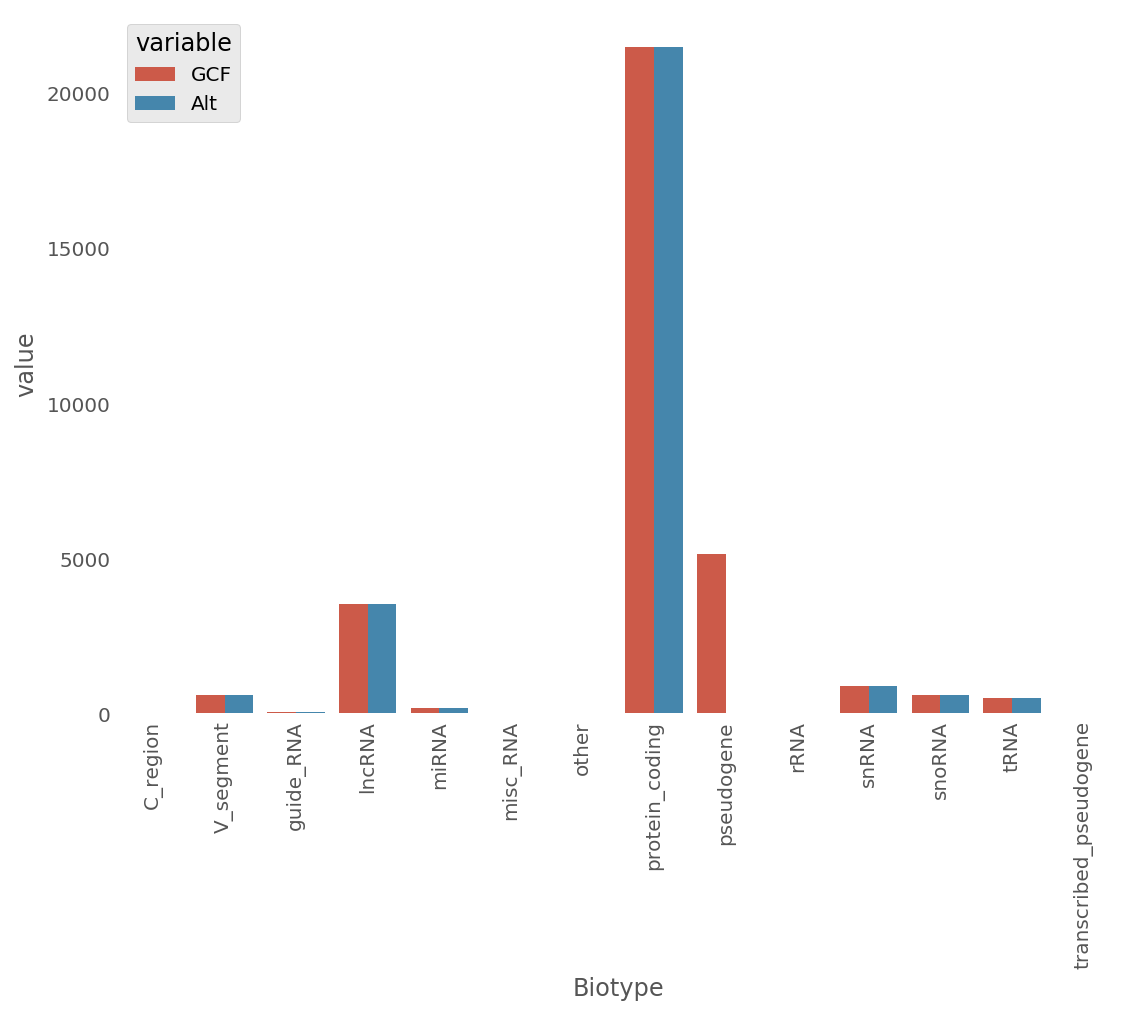

In [27]:
combined.to_csv(biotype_f)
sns.barplot(x='Biotype', y='value', hue='variable',data=combined.melt(id_vars='Biotype'))
plt.xticks(rotation=90)
helper_save(biotype_f)

## Compare the tss of the genes to see the number of start sites per gene (+isoforms)
use homer for this by getting the tss

In [28]:
gcf_tss = join(savedir,'gcf_tss.txt')
cmd = f'parseGTF.pl {gcf_in} tss > {gcf_tss}'
print(cmd)
os.system(cmd)

parseGTF.pl /data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gtf tss > genome/compare/gcf_tss.txt


0

In [29]:
alt_tss = join(savedir,'alt_tss.txt')
cmd = f'parseGTF.pl {alt_in} tss -gff3 > {alt_tss}'
print(cmd)
os.system(cmd)

parseGTF.pl /data/isshamie/genome/hamster/ncbi_anno_103/alt_CriGri-PICR_top_level.gff3 tss -gff3 > genome/compare/alt_tss.txt


0

In [30]:
gcf_tss_df = pd.read_csv(gcf_tss,sep='\t',header=None)
gcf_tss_df.head()

,0,1,2,3,4,5
0,LOC100750551_1,NW_020823976.1,39102,43102,-,.
1,LOC100751117_1,NW_020823500.1,43618,47618,+,.
2,LOC100751117_2,NW_020823764.1,8218,12218,-,.
3,LOC100751409_1,NW_020822590.1,11063,15063,-,.
4,LOC100752095_1,NW_020823574.1,51003,55003,+,.


In [31]:
alt_tss_df = pd.read_csv(alt_tss,sep='\t',header=None)
alt_tss_df.head()

,0,1,2,3,4,5
0,gene0,NW_020822366.1,97550,101550,+,.
1,gene10000,NW_020822461.1,17741672,17745672,+,.
2,gene1001,NW_020822375.1,20286412,20290412,-,.
3,gene10015,NW_020822461.1,18407121,18411121,-,.
4,gene10017,NW_020822461.1,18547342,18551342,-,.


### Number of rna tss'

In [32]:
print(len(gcf_tss_df[0].unique()))
print(gcf_tss_df.shape)
print(gcf_tss_df[0].unique())



print(len(alt_tss_df[0].unique()))
print(alt_tss_df.shape)
print(alt_tss_df[0].unique())



print(f'Number of rna in gcf: {len(gcf_tss_df[0].unique())}')
print(f'Number of rna in alt: {len(alt_tss_df[0].unique())}')


56906
(56906, 6)
['LOC100750551_1' 'LOC100751117_1' 'LOC100751117_2' ... 'XR_003488800.1'
 'XR_003488801.1' 'XR_003488802.1']
62050
(62050, 6)
['gene0' 'gene10000' 'gene1001' ... 'rna9997' 'rna9998' 'rna9999']
Number of rna in gcf: 56906
Number of rna in alt: 62050


### Collapse onto start sit

In [33]:
print(f"Number of unique TSS for GCF: {gcf_tss_df[~(gcf_tss_df.duplicated(subset=[1,2,3,4],keep='first'))].shape}")

print(f"Number of unique TSS for alt: {alt_tss_df[~(alt_tss_df.duplicated(subset=[1,2,3,4],keep='first'))].shape}")

Number of unique TSS for GCF: (43422, 6)
Number of unique TSS for alt: (48566, 6)


## Compare the start sites for GCF and alt
#create sets with the start, end, chr, and strand as tuples

In [34]:
gcf_unique = gcf_tss_df[~(gcf_tss_df.duplicated(subset=[1,2,3,4],keep='first'))]
alt_unique = alt_tss_df[~(alt_tss_df.duplicated(subset=[1,2,3,4],keep='first'))]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


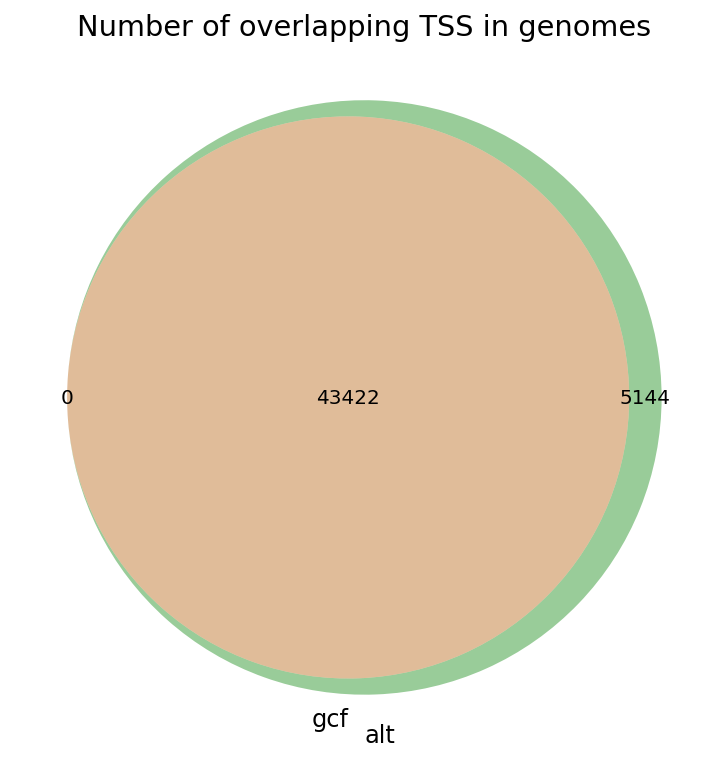

In [35]:
gcf_unique_set = set(gcf_unique.iloc[:,1:5].apply(lambda x: tuple(x.values),axis=1).values)
alt_unique_set = set(alt_unique.iloc[:,1:5].apply(lambda x: tuple(x.values),axis=1).values)

venn2(subsets=[gcf_unique_set,alt_unique_set],set_labels=("gcf","alt"))
plt.title("Number of overlapping TSS in genomes")
helper_save(tss_comparison_f)


In [36]:
alt_unique_set

{('NW_020822423.1', 31798, 35798, '+'),
 ('NW_020822439.1', 61756968, 61760968, '-'),
 ('NW_020822370.1', 38059220, 38063220, '+'),
 ('NW_020822670.1', 592410, 596410, '+'),
 ('NW_020822462.1', 4508683, 4512683, '+'),
 ('NW_020822469.1', 4282321, 4286321, '-'),
 ('NW_020822377.1', 3826256, 3830256, '+'),
 ('NW_020822531.1', 11314810, 11318810, '-'),
 ('NW_020822370.1', 10008750, 10012750, '-'),
 ('NW_020822687.1', 900117, 904117, '-'),
 ('NW_020822452.1', 3977183, 3981183, '-'),
 ('NW_020823469.1', 503857, 507857, '+'),
 ('NW_020822557.1', 1376530, 1380530, '-'),
 ('NW_020822688.1', 21378973, 21382973, '+'),
 ('NW_020823998.1', 7793, 11793, '+'),
 ('NW_020822398.1', 19142745, 19146745, '-'),
 ('NW_020822435.1', 7060430, 7064430, '-'),
 ('NW_020822840.1', -1993, 2007, '+'),
 ('NW_020822501.1', 20083863, 20087863, '-'),
 ('NW_020822630.1', 14515505, 14519505, '-'),
 ('NW_020822468.1', 4049451, 4053451, '+'),
 ('NW_020822604.1', 8879236, 8883236, '-'),
 ('NW_020822415.1', 18931323, 189353